In [177]:
from energy import Energy

### Load the script from energy.py script 

In [182]:
# %load "energy.py"

In [178]:
analysis = Energy()

In [179]:
analysis.print_data()
analysis.clean_data()
analysis.print_data()

,country,year,gdp,renewables_energy_per_capita,fossil_energy_per_capita
70,Afghanistan,1970,1.581223e+10,0.0,0.0
71,Afghanistan,1971,1.577051e+10,0.0,0.0
72,Afghanistan,1972,1.317055e+10,0.0,0.0
73,Afghanistan,1973,1.356863e+10,0.0,0.0
74,Afghanistan,1974,1.430911e+10,0.0,0.0


In [180]:
developed_countries = ["United States"]
df_dev = analysis.filter_countries(developed_countries)


under_countries = ["Morocco","Ghana","India"]
df_under = analysis.filter_countries(under_countries)

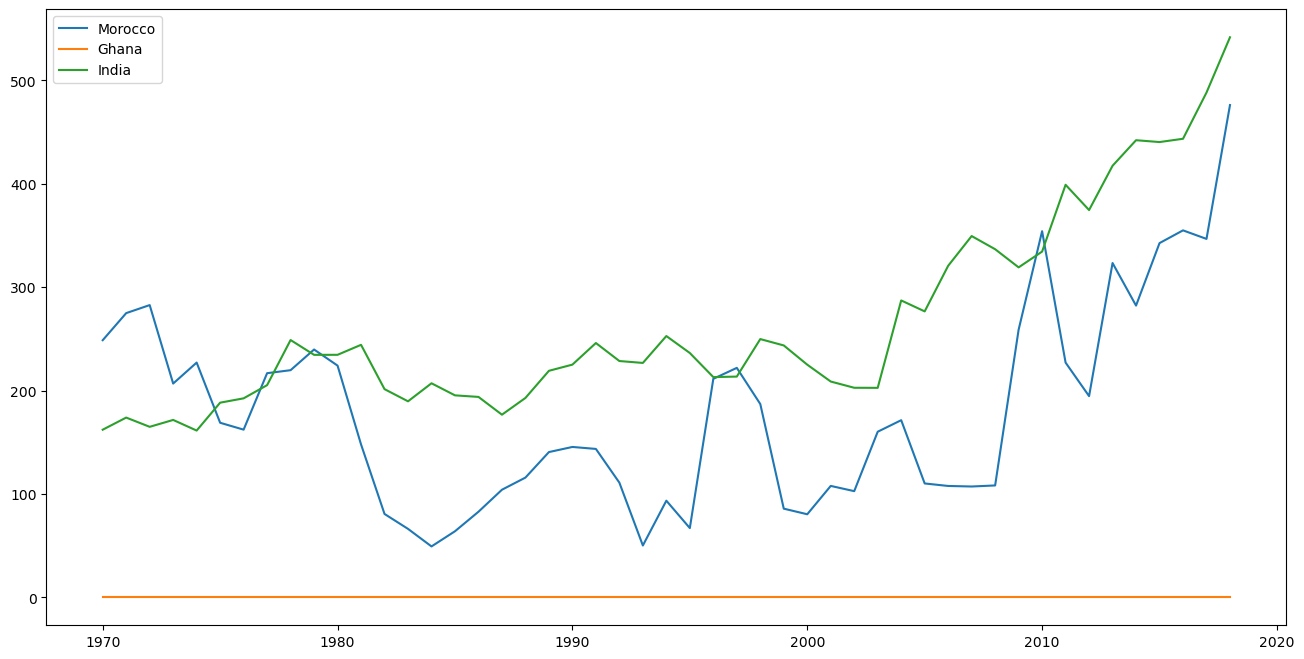

In [175]:
analysis.plots(df_under ,"renewables", countries=under_countries)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2251.624, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2267.397, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2256.476, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2238.490, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2241.632, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.90 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2250.023, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.487 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2129.907, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2128.543, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2130.572, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2131.949, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2130.263, Time=0.05 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.535 seconds
Performing stepwise search to minimize aic


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2464.818, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2463.019, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2464.333, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2464.051, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2462.910, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2464.978, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2465.951, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2466.585, Time=0.25 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 0.930 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


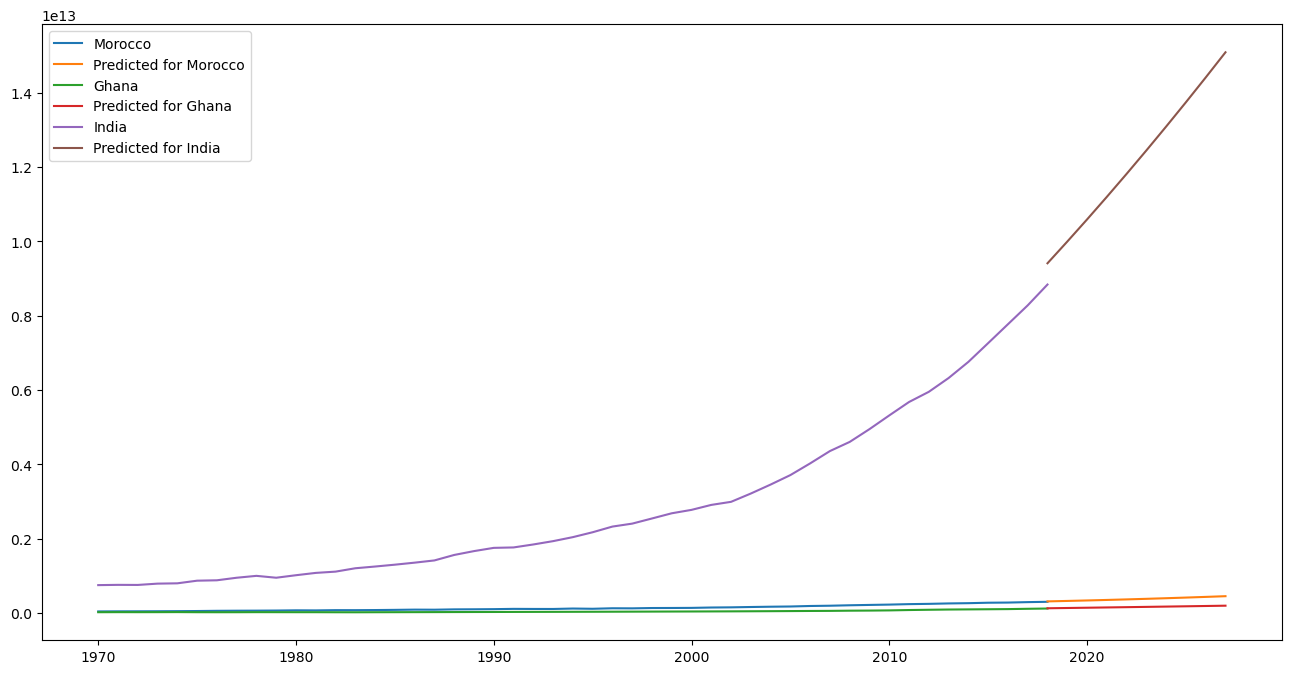

In [176]:
analysis.arima_forecast(df_under ,countries=under_countries, type="gdp")

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=537.194, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=582.753, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=538.332, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=549.693, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=538.290, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=536.047, Time=0.32 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=539.332, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=538.034, Time=0.53 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=537.979, Time=0.30 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=540.885, Time=0.37 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=534.427, Time=0.26 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=537.800, Time=0.32 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=535.818, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=536.682, 

c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=454.976, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=451.174, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=453.052, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=453.030, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=453.579, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.311 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


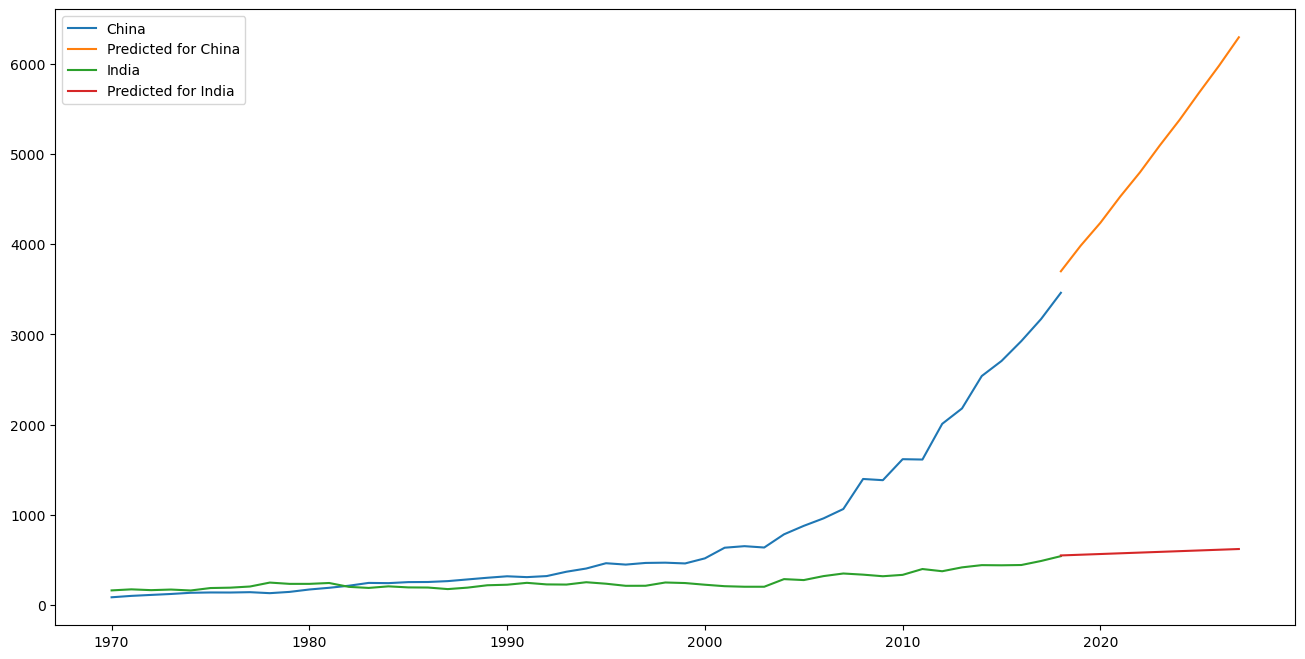

In [95]:
analysis.arima_forecast(countries=["China", "India"], type="renewables")